## GAN(간) - 생성적 적대 신경망(Generative Adversarial Networks)
  - 학습 목표 : 신경망을 통해 진짜 같은 가짜를 만들어보는 것
  - 가짜를 만들어 내는 파트를 ‘생성자(Generator)’, 진위를 가려내는 파트를 ‘판별자(Discriminator)'
  - 생성자 파트에서는 판별하기 위한 코드가 없다
  - 패딩 함수 : 마스크를 통하여 출력되면 크기가 상,하, 좌, 우 한 피셀씩 사라지는 것을 방지하기 위해, 이미지에 0으로 된 한 픽셀로 둘러준다.
  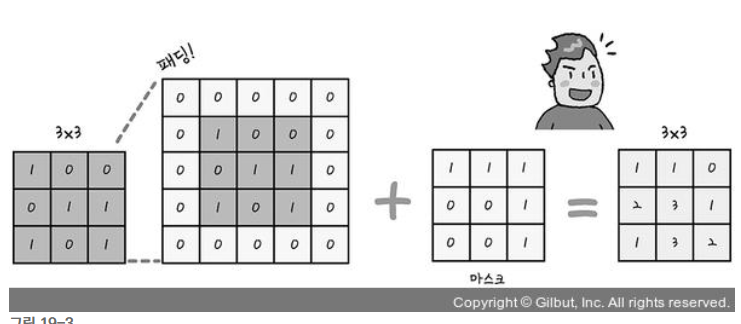
  - 배치 정규화 :  입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것인데, 다음 층으로 입력될 값을 일정하게 재배치하는 역할을 합니다. 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습을 진행할 수 있다.  BatchNormalization() 함수 사용.
  - 비 정상적인 패턴을 구분, 오류를 도출해내는 분야(신용카드 사용, 음성인식_보안)

  - 정답을 두고 맞춰가는 것 : 지도학습 (집값 계산 등 )
  - 정답 없이 비교해가며 학습 하는 것 :비지도 학습(Gan, autoencoder)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-61e4be64bcda>", line 1, in <module>
    from tensorflow.keras.datasets import mnist
  File "C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\python\__init__.py", line 45, in <module>
    from tensorflow.python import data
  File "C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\python\data\__init__.py", line 25, in <module>
    from tensorflow.python.data import experimental
  File "C:\Users\thcho\.conda\envs\dl_env\lib\site-packages\tensorflow\python\data\experimental\__init__.py", line 96, in <module>
    from tensorflow.python.data.experimental import servi

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):



KeyboardInterrupt



In [ ]:
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")


#### 생성자 : 손실하고 최적화를 사용하지 않고, 지금 만들어둔 이미지를 판별자에게 전달.  때문에 Compile이 없다.

In [ ]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2))) # 100은 임의의 숫자. 7*7 마스크, 128 채널
# LeakyReLU() 함수는 ReLU() 함수에서 x 값이 음수이면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점을 보완하기 위해, 0이하에서도 작은 값을 갖게 만드는 활성화 함수입니다.  
#케라스 함수를 이용해 ‘LeakyReLU(0.2)‘와 같은 형태로 설정하면 0보다 작을 경우 0.2를 곱하라는 의미입니다.
generator.add(BatchNormalization()) # 배치 정규화
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 사이즈를 늘려준다.
generator.add(Conv2D(64, kernel_size=5, padding='same')) #  padding='same' : 패딩함수. 사이즈 동일 
generator.add(BatchNormalization()) # 배치 정규화
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh')) # 생성자의 화소 값 : activation = 'tahn' : -1 < 값 < 1

In [ ]:
generator.summary()

  - 1층 모델 : 가중치 + 바이오스 : 100 * 128 * 7 * 7 + 128 * 7 * 7 = 633,472
  - 2층 모델 (배치 정규화) :  입력 개수 * 4 = 128 * 7 * 7 * 4 = 25,088
  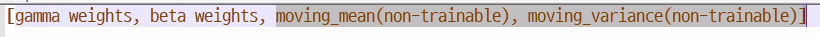
  - 3층 모델 (reshape (Reshape))
  - 4층 모델 (up_sampling2d (UpSampling2D)) : 크기 2 배
  - 5층 모델 : 가중치 + 바이오스 : 128 * 5 * 5 * 64  + 64 * 1 = 204,864  (kernel_size=5 => 5 * 5 마스크)
  - 6층 모델 : 가중치 + 바이오스 : 64 * 5 * 5 * 1 + 1 * 1 = 1,601
  
  - 모델 총 합계 : 865,281개

#### 판별자

In [ ]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same")) # strides=2 : 마스크를 두칸씩 옮겨 적용하기. 섬세하지는 못하지만 중요한 특징들을 추출할 수 있다.
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False #생성자는 판별자를 반드시 끼고 학습해야하는데, 판별자는 진본을 가지고 비교를 한다. 때문에 판별자의 학습을 막아, 판별자의 가중치 변경을 막기 위해서.

In [ ]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput)) # 판별자 함수(생성자 함수(ginput))
gan = Model(ginput, dis_output) # gan 은 ginput과 dist_output으로 만들어진 모델.
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

In [ ]:
#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 
  # 때문에 X_train만 불러왔습니다. 그리고 판별할 것이기 때문에, y 데이터도 필요가 없다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데,
  #여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다. # 판별자가 학습
          idx = np.random.randint(0, X_train.shape[0], batch_size) # 0부터 X_train.shape[0] 사이에서 batch_size만큼 빼오기.
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true) # train_on_batch() : 1회 학습 시키는 함수 # 판별자 함수를 이용하여 진짜라고 인식하는 이미지를 생성
          
          #가상 이미지를 판별자에 입력하는 부분입니다. # 판별자가 학습
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise) # 28 * 28 * 1 형태이며 - 1 에서 1 사이의 픽셀값을 도출. 
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 설정된 가중치 값으로 엉망인 이미지를 생성. 
 
          #판별자와 생성자의 오차를 계산합니다. # 생성자가 학습. 판별자의 가중치 변경을 방지 : discriminator.trainable = False
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true) # gan은 판별자는 학습 하지 않고, 생성자가 판별자를 통해 학습하기 위한 함수
          # 학습과정에서 판별자의 가중치가 업데이트 되면 안되기 때문에, 위에서 False로 지정.
          # gan은 판별자는 학습 하지 않고, 생성자만 학습하기 위한 함수. # noise가 true 인 것을 설정. 오차 인식. 

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0: # 생성된 이미지 저장.
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.
# d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 에서는 discriminator에 gen_imgs가 fake라고 학습시키며,
# g_loss = gan.train_on_batch(noise, true) 에서는 noise를 넣으면 결국 discriminator(generator(noise))가 True라고 gan을 학습시킨다.
# 그러면 결국 discriminator의 학습이 진척됨에 따라서 gan을 통해서 생성자의 학습도 나아진다는 의미
# 오차값이 적어질수록 정확하지만 판별자도 계속 학습되니까 g_loss도 별로 적어지지가 않는 것 

### 이미지의 특징을 추출하는 오토인코더
  - GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들어 내는 반면에, 오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어 낸다.
  - 특징부분을 함축하고, 특징을 이용하여 가상 이미지를 불러낸다.
  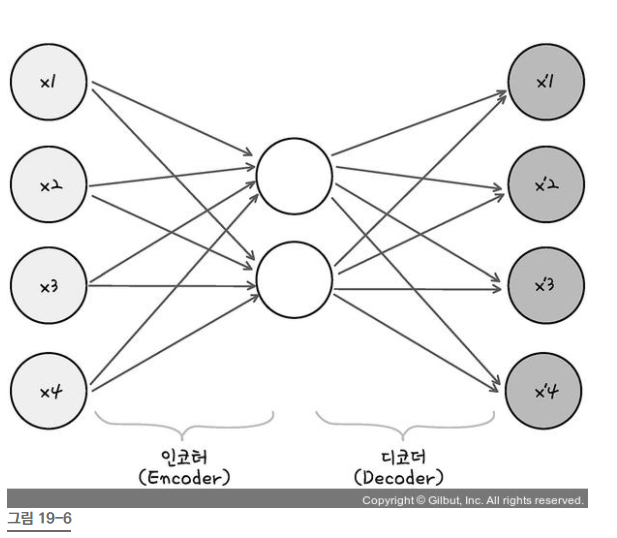- 

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255 # 0 ~ 1 사이로 픽셀 값을 조정.
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [ ]:
#생성자 모델을 만든다.
autoencoder = Sequential()

#인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding = 'same', input_shape=(28,28,1), activation='relu')) #28*28*1
autoencoder.add(MaxPooling2D(pool_size=2, padding = 'same'))#14*14*1
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))#14*14*1
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))#7*7*1
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu')) # strides가 2칸씩 옮겨져서 4*4*1

  - 최종 이미지 크기 : 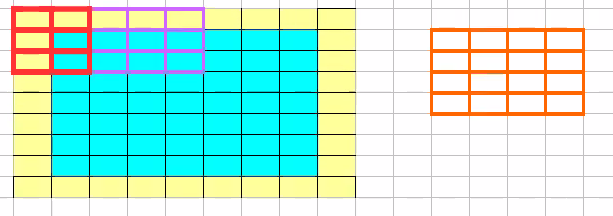

In [ ]:
# 디코딩 부분이 이어집니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 4 * 4 * 1
autoencoder.add(UpSampling2D()) # 8 * 8 * 1
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu')) # 8 * 8 * 1
autoencoder.add(UpSampling2D()) # 16 * 16 * 1
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu')) # same이 없기 때문에 상,하,좌,우 1칸씩 제거. 14 * 14 * 1
autoencoder.add(UpSampling2D()) # 28 * 28 * 1
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

In [ ]:
autoencoder.summary()

In [ ]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

In [ ]:
#학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  #테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)  #앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))  #출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):    #랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))  #테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  #오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

## 전이 학습을 통해 딥러닝의 성능 극대화하기
  - 딥러닝의 데이터 양이 충분하지 않을 때 활용할 수 있는 방법
  - 전이 학습(transfer learning) : 수만 장에 달하는 기존의 이미지에서 학습한 정보를 가져와 내 프로젝트에 활용하는 것
  - 방대한 자료를 통해 미리 학습한 가중치(weight)값을 가져와 내 프로젝트에 사용하는 방법
  - 데이터의 수를 늘리는 ImageDataGenerator() 함수와 폴더에 저장된 데이터를 불러오는 flow_from_directory() 함수를 사용
  - 이전 vs convolustion 
    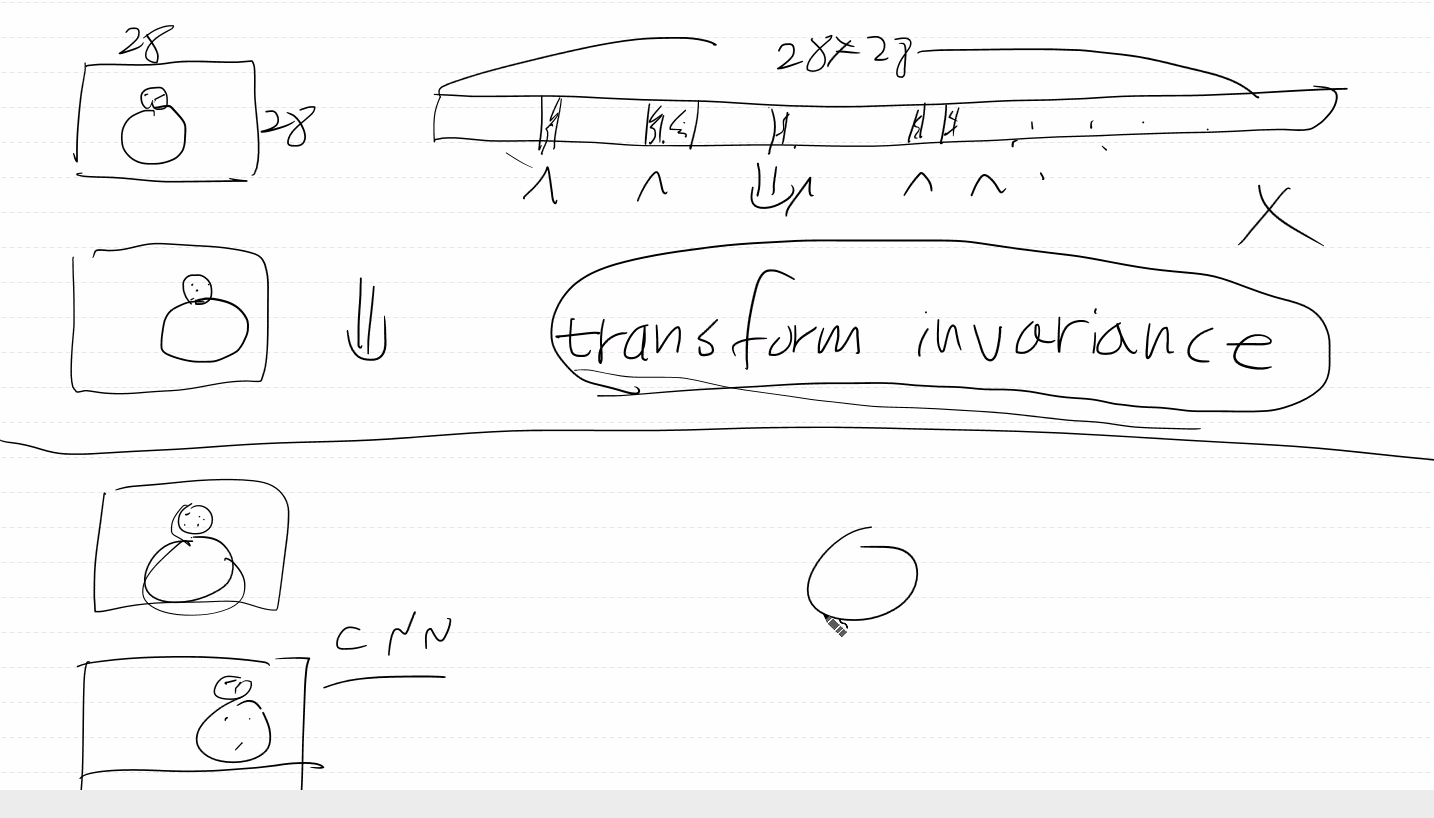

  - ImageDataGenerator() 함수 : 주어진 데이터를 이용해 변형된 이미지를 만들어 학습셋에 포함시키는 편리한 기능을 제공
  - 모든 기능을 무조선 사용하는 것은 x. 뒤집었을 때에는, 이미지가 변형되는 것으로 인지될 수 있는 경우가 있으므로.
  - train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=5, shear_range=0.7, zoom_range=1.2, vertical_flip=True, fill_mode=‘nearest’)
  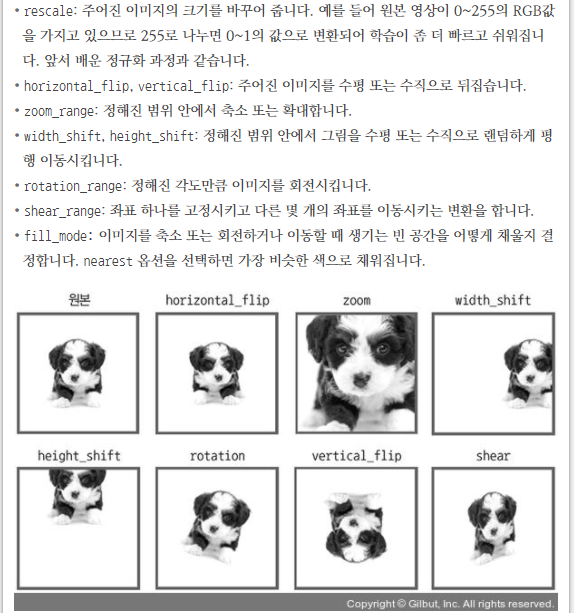

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,  
                                  horizontal_flip=True,     #수평 대칭 이미지를 랜덤으로 만들어 추가합니다.
                                  width_shift_range=0.1,  #전체 크기의 10% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1, #마찬가지로 위, 아래로 이동합니다.,
                                  fill_mode='nearest') 

In [ ]:
train_generator = train_datagen.flow_from_directory(
       'example/080228-master/deeplearning/run_project/train',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary') #폴더를 지정해주면, train 안에 있는 ad와 normal을 0, 1 형식으로 인식한다.

In [ ]:
#테스트 셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)  

In [ ]:
test_generator = test_datagen.flow_from_directory(
       'example/080228-master/deeplearning/run_project/test',   #테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')


In [ ]:
len(train_generator) # 160개 이미지를 batch_size=5 로 배치하기 위해서 len 값이 32

In [ ]:
len(test_generator) # 120개 이미지를 batch_size=5 로 배치하기 위해서 len 값이 24 

In [ ]:
# 앞서 배운 CNN 모델을 만들어 적용해 보겠습니다.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

In [ ]:
#모델을 컴파일 합니다. 
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])
# loss='sparse_categorical_crossentropy' : 모델의 출력이 원 핫 인코딩을 아닌, 모델의 출력이 0, 1, 2 등 정수로 나올 때 그대로 사용하기 위해서 
# learning_rate=0.0002 는 저자가 실험결과로써 이렇게 코드르르 사용할 수 있다는 것 을 알려주기위해 적어놓은 것

In [ ]:
#모델을 실행합니다
history = model.fit(# fit_generator에서 fit으로 통합됨.
       train_generator,
       steps_per_epoch=len(train_generator), #원래 이미지의 개수를 초과하지 않게 변경됨
       epochs=40,   #적절한 값으로 조절합니다.
       validation_data=test_generator,
       validation_steps=len(test_generator))

In [ ]:
#결과를 그래프로 표현하는 부분입니다.
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

  - 케라스 5장의 데이터 증식 사용하기

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics


In [6]:
import os, shutil

original_dataset_dir = 'example/080228-master/deeplearning/dogs-vs-cats/train'

base_dir = 'example\\080228-master\\deeplearning\\cats_and_dogs_small'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames :
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)] #검증용이지만 test로 만든다
for fname in fnames :
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)    

In [7]:
print(len(os.listdir(train_dir)))

1000


In [8]:
print(len(os.listdir('example/080228-master/deeplearning/cats_and_dogs_small/train')))

1000


In [9]:
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1, 
                             height_shift_range=0.1,
                             shear_range=0.1, 
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest') 

In [12]:
from tensorflow.keras.preprocessing import image 
fnames = sorted([os.path.join(train_dir, fname) for 
                fname in os.listdir(train_dir)])

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150,150))

x = image.img_to_array(img)
x = x.reshape((1,)+x.shape)

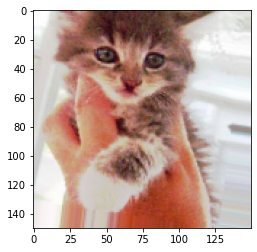

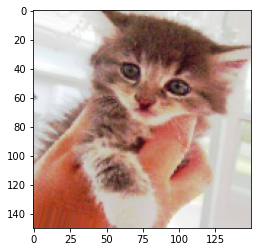

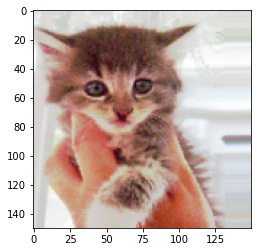

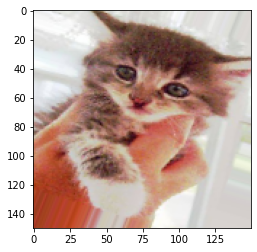

In [13]:
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1 
    if i %4 == 0:
        break
    
plt.show()

In [14]:
# 앞서 배운 CNN 모델을 만들어 적용해 보겠습니다.
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [17]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,  
                                  rotation_range=40,
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True) 

In [19]:
#테스트 셋은 이미지 부풀리기 과정을 진행하지 않습니다.
test_datagen = ImageDataGenerator(rescale=1./255)  

In [20]:
base_dir = 'example\\080228-master\\deeplearning\\cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')


In [21]:
train_generator = train_datagen.flow_from_directory(
       train_dir,   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=32,
       class_mode='binary') #폴더를 지정해주면, train 안에 있는 ad와 normal을 0, 1 형식으로 인식한다.

Found 1000 images belonging to 1 classes.


In [38]:
train_dir

'example\\080228-master\\deeplearning\\cats_and_dogs_small\\train'

In [20]:
test_generator = test_datagen.flow_from_directory(
       test_dir,   #테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=32,
       class_mode='binary')


Found 0 images belonging to 0 classes.


In [21]:
#모델을 실행합니다
history = model.fit(# fit_generator에서 fit으로 통합됨.
       train_generator,
       steps_per_epoch=len(train_generator), #원래 이미지의 개수를 초과하지 않게 변경됨
       epochs=40,   #적절한 값으로 조절합니다.
       validation_data=test_generator,
       validation_steps=len(test_generator))

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [22]:
train_dir

'example/080228-master/deeplearning/cats_and_dogs_small\\train'

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'